# Velocity Test

## Set-up

### Load libraries

In [6]:
# load modules for interacting with files and folders
import os
# load modules for plotting
import matplotlib
import matplotlib.pyplot as plt

# load modules for writing sound files
import soundfile as sf

# load modules from the librosa library for acoustic processing and analysis
import librosa
import librosa.display # for displaying acoustic information
import librosa.feature # for extracting and working with audio features


# load module for playing sound files within the notebook
from IPython.display import Audio, display


# load modules for doing math
import numpy as np
import numpy.linalg as LA

### Audio Processing

In [51]:
default_res = 3
default_pad = 0.25

# using liftering, recover fourier data from mfcc data
def lifter_mfcc(mfcc):
  mel_from_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc)
  fourier_from_mel = librosa.feature.inverse.mel_to_stft(mel_from_mfcc)
  return fourier_from_mel

# get audio data, including fourier representation and mfcc features,
# from a sound file given the file name 'fn'
def process_audio(fn, n_mfcc_list = [12], duration = 0, offset = 0, pad = default_pad, pre_emph = True, res = default_res):
  out_dict = {}
  if duration == 0:
    timeseries, sample_rate = librosa.load(fn, offset = offset)
  else:
    timeseries, sample_rate = librosa.load(fn, duration = duration, offset = offset)
  # apply a pre-emphasis filter
  if pre_emph:
    timeseries = librosa.effects.preemphasis(timeseries)
  if pad > 0:
    padding_frames = round(pad*sample_rate)
    padding = np.zeros((padding_frames))
    timeseries = np.concatenate([padding,timeseries,padding])
  dur = librosa.get_duration(y=timeseries, # measure the duration of the sound clip,
                                sr=sample_rate) # assuming sample rate "sr"
  fourier = np.abs(librosa.stft(timeseries))
  mfcc_dict = {}
  for n_mfcc in n_mfcc_list:
    mfcc = librosa.feature.mfcc(timeseries, n_mfcc = n_mfcc,hop_length=2**(9-res))
    mfcc_dict[str(n_mfcc)] = mfcc
  #liftered = lifter_mfcc_array(mfcc)
  out_dict["fn"] = fn
  out_dict["sr"] = sample_rate
  out_dict["start"] = offset
  out_dict["end"] = offset + duration
  out_dict["dur"] = dur
  out_dict["fourier"] = fourier
  out_dict["mfcc_ns"] = n_mfcc_list
  out_dict["mfcc"] = mfcc_dict
  #out_dict["liftered"] = liftered
  return out_dict

# export an audio file to filename 'fn' from the fourier data
def export_audio_from_fourier(fn,fourier,sr,de_emph = True):
  timeseries_from_fourier = librosa.griffinlim(fourier)
  # undo a preemphasis filter
  if de_emph:
    timeseries_from_fourier = librosa.effects.deemphasis(timeseries_from_fourier)
  sf.write(fn, timeseries_from_fourier, sr, subtype='PCM_24')

  # export an audio file to filename 'fn' from the fourier data
def export_audio(fn,audio_data,de_emph = True):
  fourier = audio_data["fourier"]
  sr = audio_data["sr"]
  timeseries_from_fourier = librosa.griffinlim(fourier)
  # undo a preemphasis filter
  if de_emph:
    timeseries_from_fourier = librosa.effects.deemphasis(timeseries_from_fourier)
  sf.write(fn, timeseries_from_fourier, sr, subtype='PCM_24')

In [101]:
def plot_mel_spectrogram(fourier,sr,res=default_res,title='Mel-frequency spectrogram'):
  timeseries_from_fourier = librosa.griffinlim(fourier)
  mel = librosa.feature.melspectrogram(timeseries_from_fourier,sr,hop_length=2**(9-res))
  fig, ax = plt.subplots()
  #ax.set_aspect(1/1000)
  mel_dB = librosa.power_to_db(mel, ref=np.max)
  img = librosa.display.specshow(mel_dB, x_axis='time',
                         y_axis='mel', sr=sr*2**res, cmap='gray_r',
                         fmax=8192, ax=ax)
  fig.colorbar(img, ax=[ax])
  title = ax.set(title=title)


def plot_mfcc(mfcc,sr,title,res=default_res,title='MFCC'):
  fig, ax = plt.subplots()
  #ax.set_aspect(1/100)
  img = librosa.display.specshow(mfcc, x_axis='time', 
                         y_axis='mel', sr=sr*2**res, #cmap='gray_r',
                         fmax=8192, ax=ax)
  fig.colorbar(img, ax=[ax])
  title = ax.set(title=title)

def plot_timeseries(data,sr,title='data'):
  data = np.squeeze(data)
  times = librosa.times_like(data,sr)
  fig, ax = plt.subplots()
  #librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='linear', x_axis='time', ax=ax)
  ax.plot(times, data, color='black')
  ax.set(title=title)

def show_the_spectrogram(audio_data,res=default_res):
  fourier = audio_data["fourier"]
  sr = audio_data["sr"]
  plot_mel_spectrogram(fourier,sr,res=res)

def show_the_mfcc(audio_data,mfcc_n,res=default_res):
  mfcc = audio_data["mfcc"][str(mfcc_n)]
  sr = audio_data["sr"]
  title='MFCC'+str(mfcc_n)
  if mfcc_n == 1:
    return plot_timeseries(mfcc,sr*2**res,title=title)
  plot_mfcc(mfcc,sr,title,res=res)

SyntaxError: ignored

### Test of Audio Processing

#### Load an audio file

In [102]:
clip_fn = "sound/American-English/Narrative/narrative1.wav"
out_path = 'sound/out/'

clip_data = process_audio(clip_fn,duration=1.2,n_mfcc_list=[1,5,12,20])
export_audio(out_path+"clip_from_fourier.wav",clip_data)
Audio(out_path+"clip_from_fourier.wav")

#### Display audio data

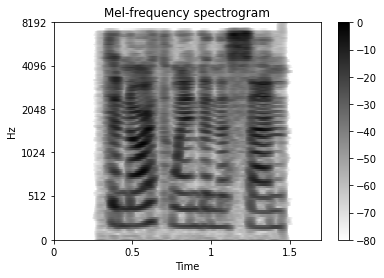

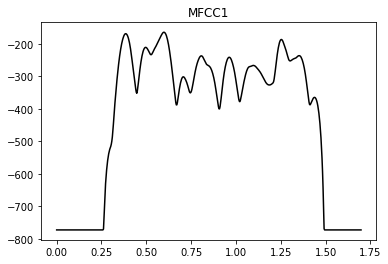

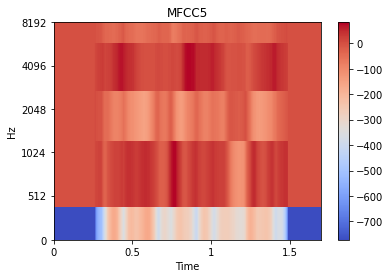

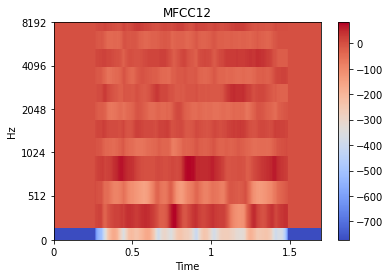

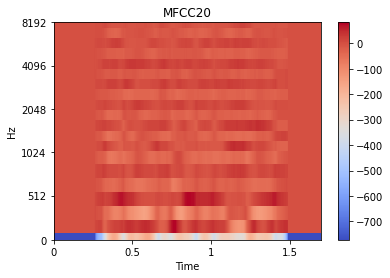

In [103]:
show_the_spectrogram(clip_data)
for n in clip_data["mfcc_ns"]:
  show_the_mfcc(clip_data,n)

## Acoustic velocity

### Getting acoustic velocity

In [104]:
def split_frames(mfcc):
  frame_n = mfcc.shape[1]
  frame_list = np.split(mfcc,frame_n,axis=1)
  return frame_list

def stack_frames(frame_list):
  mfcc = np.concatenate(frame_list,axis=1)
  return mfcc

def trunc_mfcc(mfcc,frame_shift,front=True):
  frame_list = split_frames(mfcc)
  if front:
    trunc_list = frame_list[frame_shift:]
  else:
    trunc_list = frame_list[:-frame_shift]
  new_mfcc = stack_frames(trunc_list)
  return new_mfcc

def get_mfcc_diff(mfcc,frame_shift):
  front_mfcc = trunc_mfcc(mfcc,frame_shift,front=True)
  back_mfcc = trunc_mfcc(mfcc,frame_shift,front=False)
  diff_mfcc = np.subtract(back_mfcc,front_mfcc)
  return diff_mfcc

def L2(v):
  norm = LA.norm(v,ord=2)
  return(norm)

def L1(v):
  norm = LA.norm(v,ord=1)
  return(norm)

def Ln1(v):
  norm = LA.norm(v,ord=-1)
  return(norm)

def get_norms(mfcc,norm=L2):
  frames = split_frames(mfcc)
  norms= [norm(v) for v in frames]
  norm_array = np.array(norms)
  return norm_array

def get_vels(mfcc,frame_shift,norm=L2):
  diff = get_mfcc_diff(mfcc,frame_shift)
  vels = get_norms(diff)
  return vels

def show_the_vels(audio_data,mfcc_n,frame_shift=1,norm=Ln1,res=default_res,plot_spec=True,show_mfcc=True):
  mfcc = audio_data["mfcc"][str(mfcc_n)]
  sr = audio_data["sr"]
  title = "Audio Velocity from MFCC"+str(mfcc_n)
  vels = get_vels(mfcc,frame_shift,norm=norm)
  plot_timeseries(vels,sr=sr*2**res,title=title)
  if plot_spec:
    show_the_spectrogram(audio_data)
  if show_mfcc:
    show_the_mfcc(audio_data,mfcc_n)

### Test of acoustic velocity

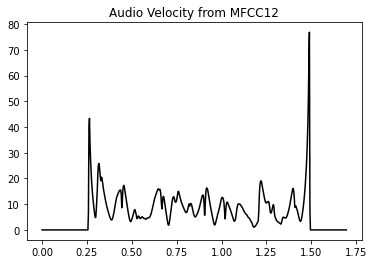

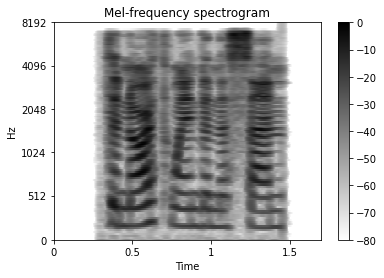

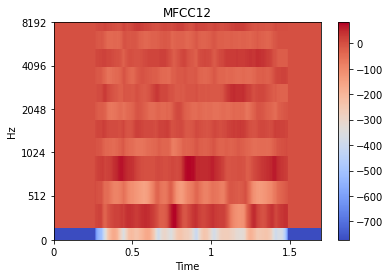

In [105]:
Audio(out_path+"clip_from_fourier.wav")
show_the_vels(clip_data,12)

## More testing

### Load more audio files

In [106]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

narrative_fns = []
consonants_fns = []
vowels_fns = []
nonspeech_fns = []

fns = [narrative_fns,consonants_fns,vowels_fns,nonspeech_fns]

for i,path in enumerate(paths):
  for root, dirs, files in os.walk(path):
      for file in files:
          fns[i].append(os.path.join(root,file))

In [107]:
default_mfcc_ns = [1,5,12,20]
narrative_data = [process_audio(fn,n_mfcc_list=default_mfcc_ns) for fn in narrative_fns]
vowels_data = [process_audio(fn,n_mfcc_list=default_mfcc_ns) for fn in vowels_fns]
consonants_data = [process_audio(fn,n_mfcc_list=default_mfcc_ns) for fn in consonants_fns]
nonspeech_data = [process_audio(fn,duration=2,n_mfcc_list=default_mfcc_ns) for fn in nonspeech_fns]

### Test a "vowel" word

above


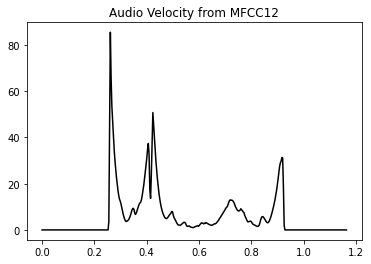

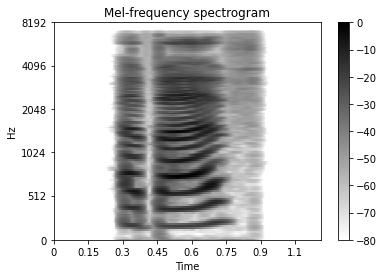

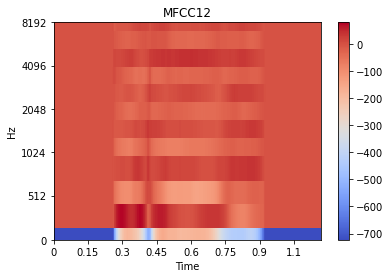

In [108]:
i=6
name = vowels_data[i]["fn"].split('/')[-1]
name = name.split('.')[0]
print(name)
vowel_out = out_path+name+'_from_fourier.wav'
export_audio(vowel_out,vowels_data[i])
Audio(vowel_out)
show_the_vels(vowels_data[i],12)

### Test a "consonant" word

chin


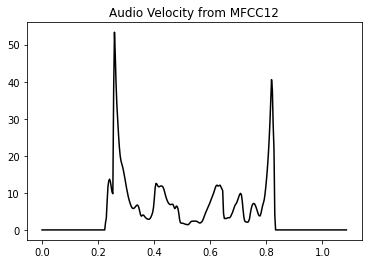

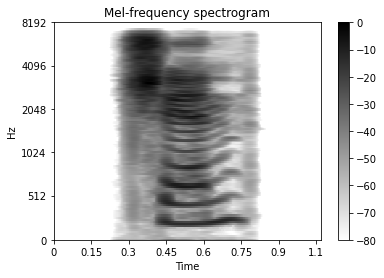

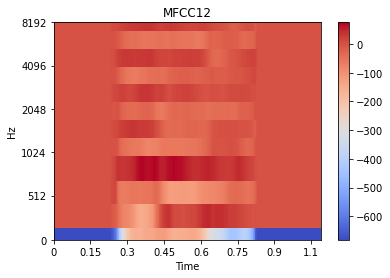

In [109]:
i=0
name = consonants_data[i]["fn"].split('/')[-1]
name = name.split('.')[0]
print(name)
consonant_out = out_path+name+'_from_fourier.wav'
export_audio(consonant_out,consonants_data[i])
Audio(consonant_out)
show_the_vels(consonants_data[i],12)

### Test a nonspeech sound

train


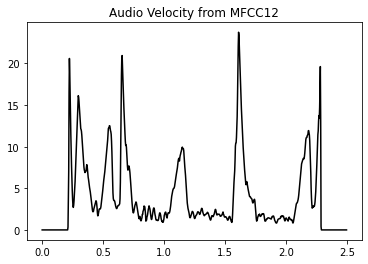

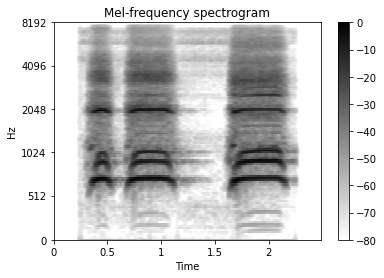

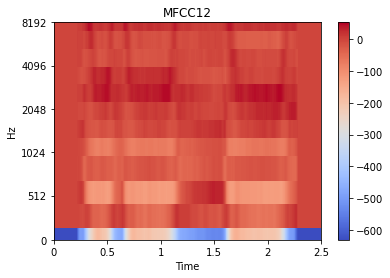

In [110]:
i=1
name = nonspeech_data[i]["fn"].split('/')[-1]
name = name.split('.')[0]
print(name)
nonspeech_out = out_path+name+'_from_fourier.wav'
export_audio(nonspeech_out,nonspeech_data[i])
Audio(nonspeech_out)
show_the_vels(nonspeech_data[i],12)

## Norming MFCCs

### Normalize a spectral array

In [111]:
def norm_array(array,norm=L2):
  frames = split_frames(array)
  norms = [norm(v) for v in frames]
  recips = [1 if n== 0 else 1/n for n in norms]
  normed_frames = [f*r for f,r in zip(frames,recips)]
  normed_array = stack_frames(normed_frames)
  return normed_array  

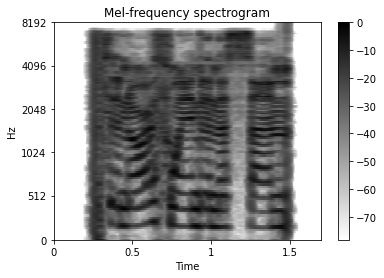

In [112]:
my_normed_array = norm_array(clip_data["fourier"])
plot_mel_spectrogram(my_normed_array,clip_data["sr"])
normed_fn = out_path+"normalized_clip.wav"
export_audio_from_fourier(normed_fn,my_normed_array,clip_data["sr"],de_emph=False)
Audio(normed_fn)

### Norming and getting acoustic velocity

In [121]:
def get_normed_vels(mfcc,frame_shift,norm=L2):
  normed_mfcc = norm_array(mfcc,norm=norm)
  diff = get_mfcc_diff(normed_mfcc,frame_shift)
  vels = get_norms(diff)
  return vels

def show_the_normed_vels(audio_data,mfcc_n,frame_shift=1,norm=Ln1,res=default_res,show_spec=True,show_mfcc=True):
  mfcc = audio_data["mfcc"][str(mfcc_n)]
  sr = audio_data["sr"]
  title = "Audio Velocity from normed MFCC"+str(mfcc_n)
  vels = get_normed_vels(mfcc,frame_shift,norm=norm)
  plot_timeseries(vels,sr=sr*2**res,title=title)
  if show_spec:
    plot_mel_spectrogram(norm_array(audio_data["fourier"]),audio_data["sr"],title='Normed Mel-frequency spectrogram')
  if show_mfcc:
    plot_mfcc(norm_array(mfcc),audio_data["sr"],title='Normed MFCC'+str(mfcc_n))

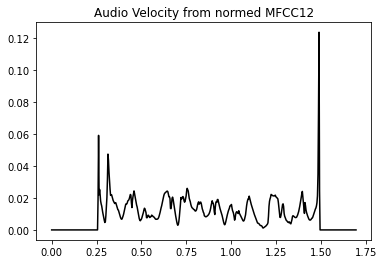

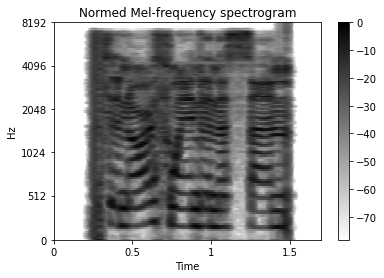

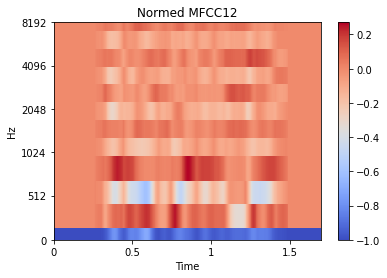

In [122]:
Audio(out_path+"clip_from_fourier.wav")
show_the_normed_vels(clip_data,12)

### Test of normed acoustic velocity

above


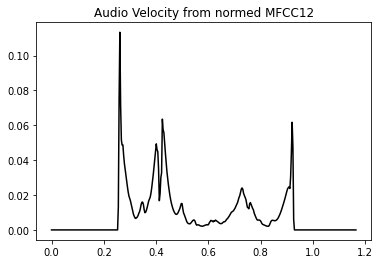

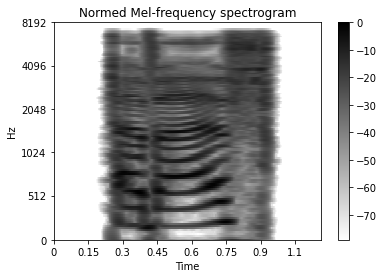

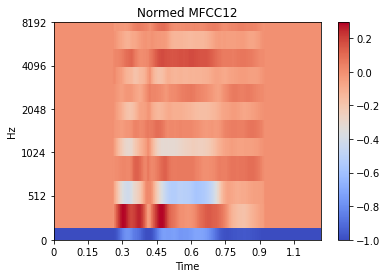

In [123]:
i=6
name = vowels_data[i]["fn"].split('/')[-1]
name = name.split('.')[0]
print(name)
vowel_out = out_path+name+'_from_fourier.wav'
export_audio(vowel_out,vowels_data[i])
Audio(vowel_out)
show_the_normed_vels(vowels_data[i],12,norm=Ln1)

above


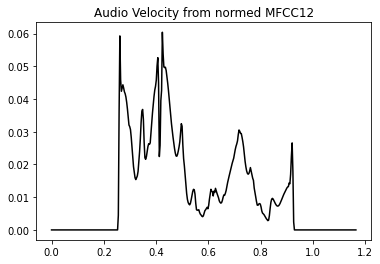

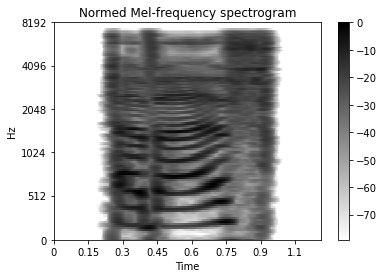

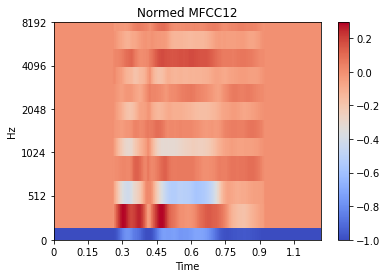

In [124]:
i=6
name = vowels_data[i]["fn"].split('/')[-1]
name = name.split('.')[0]
print(name)
vowel_out = out_path+name+'_from_fourier.wav'
export_audio(vowel_out,vowels_data[i])
Audio(vowel_out)
show_the_normed_vels(vowels_data[i],12,norm=L2)